### Check type of GPU and VRAM available.

In [1]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

A100-SXM4-40GB, 40536 MiB, 40536 MiB


# Clone repos we need


In [11]:
!git clone https://github.com/Jan-Oliver/profaile-pic-dev.git

fatal: destination path 'profaile-pic-dev' already exists and is not an empty directory.
Cloning into 'ETH-IACV-SD2'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 23 (delta 4), reused 23 (delta 4), pack-reused 0
Unpacking objects: 100% (23/23), done.


In [3]:
# Handle all of the dependencies
!cd /content/profaile-pic-dev && pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/diffusers.git to /tmp/pip-req-build-6drt74ku
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers.git /tmp/pip-req-build-6drt74ku
  Resolved https://github.com/huggingface/diffusers.git to commit 9b37ed33b5fa09e594b38e4e6f7477beff3bd66a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-367gjait
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-367gjait
  Resolved https://github.com/huggingface/transformers.git to commit 056218dab1e59939a14f085ce5edcdd166053073
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pypro

### Connect to GDrive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Just leave everything as it is

In [5]:
# Store model weights here
OUTPUT_DIR = "/content/stable_diffusion_weights/train"
# We will use prior preservation
CLASS_IMAGES_DIR = None
# 2.1 with 512x512 resolution 
MODEL_NAME = "stabilityai/stable-diffusion-2-1-base"
# Use Floating Point 16 -> Reduce VRAM of GPU
PRECISION = "fp16"
# Make folders
!mkdir -p $OUTPUT_DIR

### Adapt this:
- YOUR_NAME_ABBREVIATION: Simply use the first letter of your first name and then your last name.
- MALE_OR_FEMALE: If you are a man, set this to man. If you are a woman, set this to woman.


**Why do we need this**?:
- This is based on the Dreambooth Paper. You can find it [here](https://dreambooth.github.io)

In [6]:
YOUR_NAME_ABBREVIATION = "qonvhs"
MAN_OR_WOMAN = "man"

In [7]:
concepts_list = [
    {
        "instance_prompt":      f"photo of {YOUR_NAME_ABBREVIATION} {MAN_OR_WOMAN}",
        "class_prompt":         f"photo of a {MAN_OR_WOMAN}",
        "instance_data_dir":    "/content/data/instance_images",
        "class_data_dir":       "/content/data/class_images"
    }
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)
    os.makedirs(c["class_data_dir"], exist_ok=True)

with open("concepts_list.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [9]:
import shutil
class_images = "/content/drive/MyDrive/StableDiffusion/class_pictures_man"
for file_name in os.listdir(class_images):
    full_file_name = os.path.join(class_images, file_name)
    shutil.copy(full_file_name, "/content/data/class_images")

### Now upload 10 images into /data/instance_data_dir
- They all have to be cropped to 512x512. 
- To do that use [this mass cropping tool](https://www.birme.net)
- Make sure your it is only you on the images and you have quite a bit of variable poses, etc.

### Launch the training

In [13]:
!accelerate launch /content/ETH-IACV-SD2/dreambooth/train_dreambooth.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-2-1-base" \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir="/content/stable_diffusion_weights/train" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="no" \
  --gradient_accumulation_steps=1 \
  --gradient_checkpointing \
  --learning_rate=1e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=100 \
  --sample_batch_size=4 \
  --max_train_steps=3000 \
  --save_interval=1000 \
  --save_min_steps=1000 \
  --save_sample_prompt=f"medium shot side profile portrait photo of the {YOUR_NAME_ABBREVIATION} {MAN_OR_WOMAN} warrior chief, tribal panther make up, blue on red, looking away, serious eyes, 50mm portrait, photography, hard rim lighting photography –ar 2:3 –beta –upbeta" \
  --save_sample_negative_prompt="blender, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white" \
  --n_save_sample=4 \
  --save_guidance_scale=7.5 \
  --save_infer_steps=50 \
  --concepts_list="concepts_list.json" \
  --use_8bit_adam

# Reduce the `--save_interval` to lower than `--max_train_steps` to save weights from intermediate steps.
# `--save_sample_prompt` can be same as `--instance_prompt` to generate intermediate samples (saved along with weights in samples directory).

2023-01-14 22:40:14.118670: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
Caching latents: 100% 100/100 [00:10<00:00,  9.67it/s]
Steps:  33% 1000/3000 [07:50<15:29,  2.15it/s, loss=0.282, lr=1e-6]
Fetching 16 files: 100% 16/16 [00:00<00:00, 23763.76it/s]

Generating samples:   0% 0/4 [00:00<?, ?it/s]
Generating samples:  25% 1/4 [00:07<00:23,  7.67s/it]
Generating samples:  50% 2/4 [00:10<00:10,  5.04s/it]
Generating samples:  75% 3/4 [00:14<00:04,  4.19s/it]
Generating samples: 100%

### Preview the results

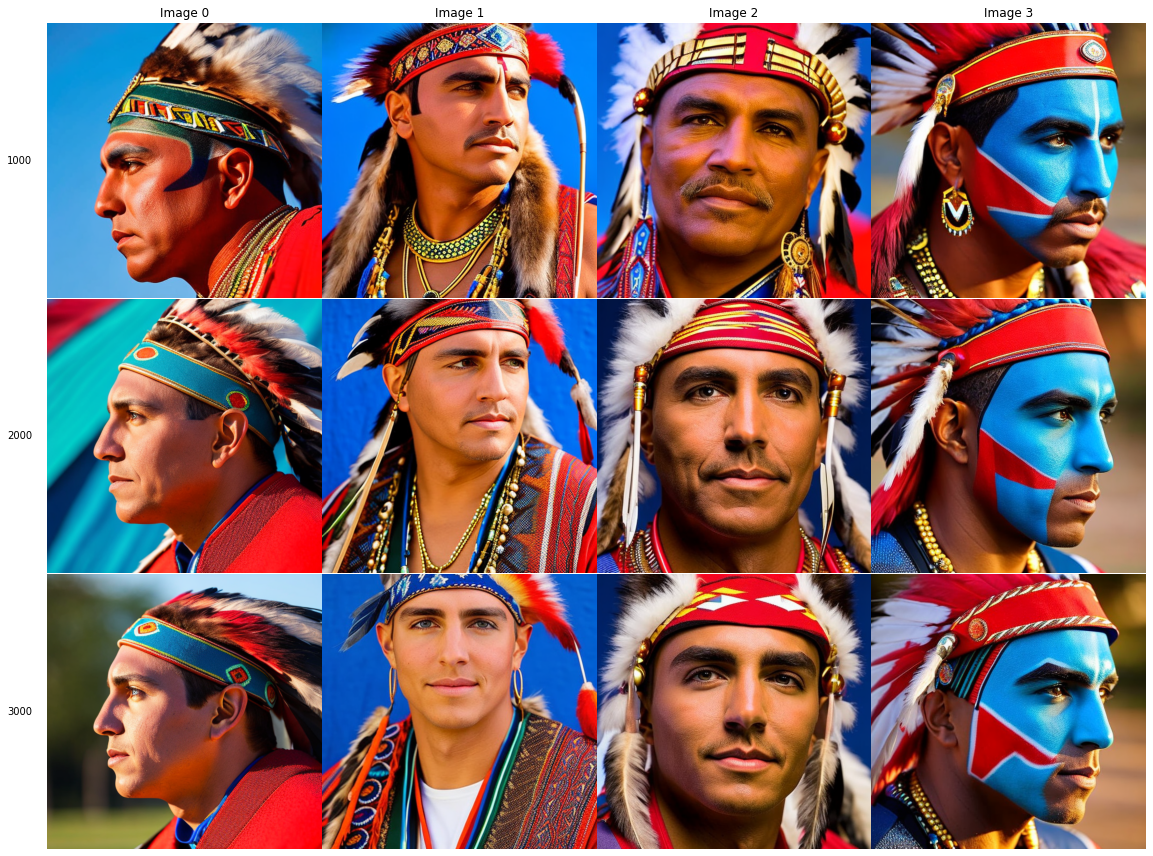

In [14]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('grid.png', dpi=72)

### Select the weights to use

In [15]:
WEIGHTS_DIR = os.path.join(OUTPUT_DIR, "3000")
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=/content/stable_diffusion_weights/train/3000


### Push model to Google Drive so you can use it later

- Adapt this path: PATH_TO_COPY_MODEL_TO_GDRIVE where you want to upload the trained model to

In [ ]:
import shutil
PATH_TO_COPY_MODEL_TO_GDRIVE = ""
shutil.copytree(WEIGHTS_DIR, )

## Part 2 Inference

### Util stuff

In [26]:
# Util functions
from PIL import Image
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler, EulerDiscreteScheduler
from IPython.display import display

if PRECISION == "fp16":
    fp16 = True
else:
    fp16 = False

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

scheduler_euler = EulerDiscreteScheduler.from_pretrained(MODEL_NAME, subfolder="scheduler")
scheduler_ddim = DDIMScheduler.from_pretrained(MODEL_NAME,subfolder="scheduler")

# First for Euler
if fp16:
  pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler_ddim, safety_checker=None, torch_dtype=torch.float16).to("cuda")
else:
  pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler_ddim, safety_checker=None, torch_dtype=torch.float32).to("cuda")

# Then for DDIM
g_cuda = torch.Generator(device='cuda').manual_seed(52362)

num_samples = 10
guidance_scale = 7
num_inference_steps = 70
height = 512
width = 512

### Play around with these parameters.
- Note: If you want to be in the image you have to add your abbreviation and gender into the positive promt.
- Run the next cell to generate the images.

In [ ]:
YOUR_NAME_ABBREVIATION = "mshymyr"
MAN_OR_WOMAN = "man"

Token indices sequence length is longer than the specified maximum sequence length for this model (84 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', hasselblad, candid street portrait']


  0%|          | 0/70 [00:00<?, ?it/s]

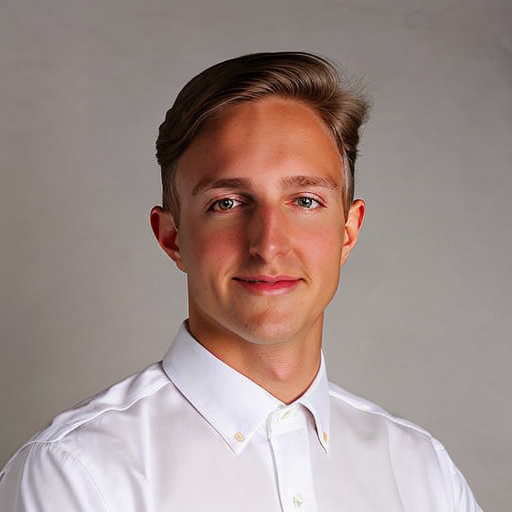

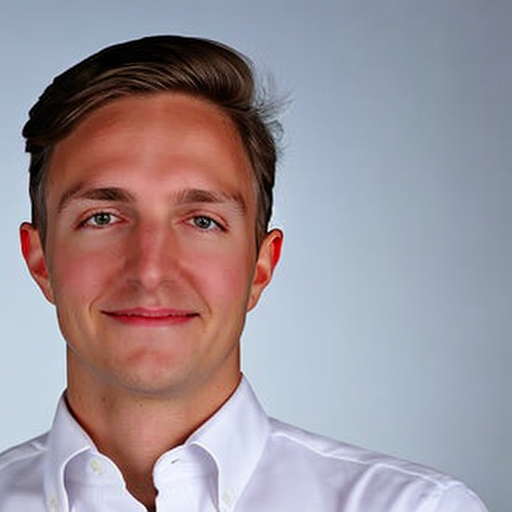

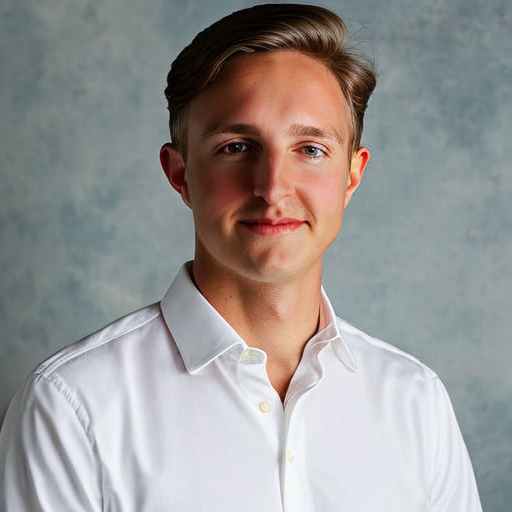

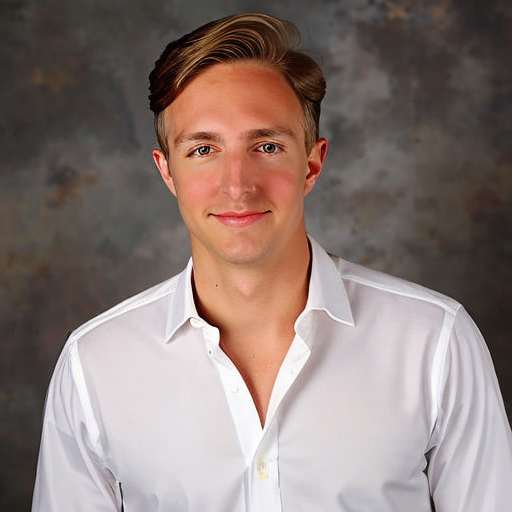

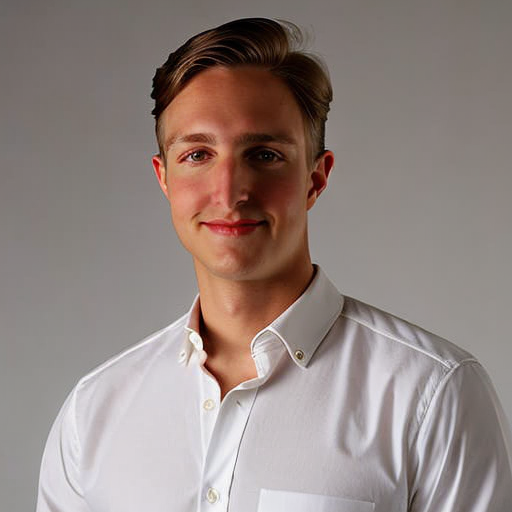

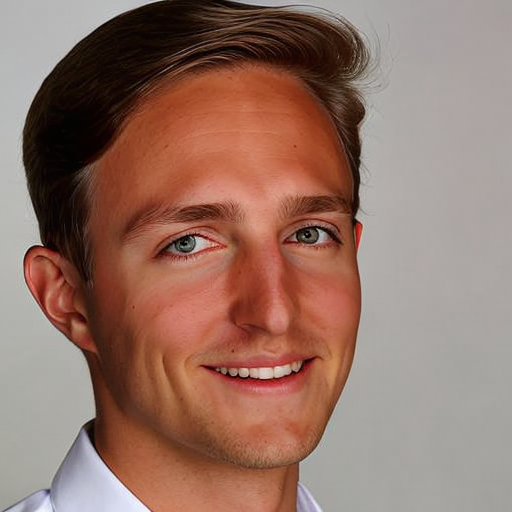

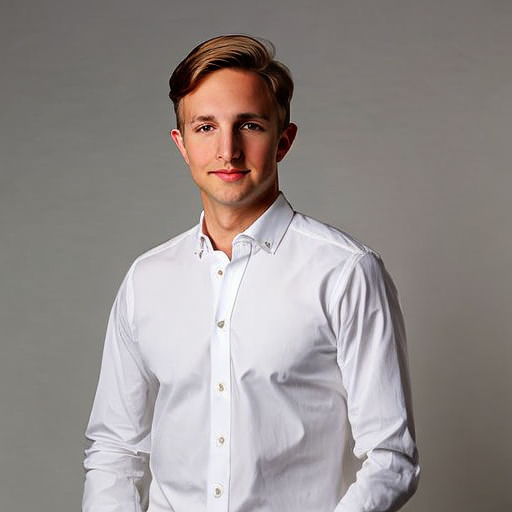

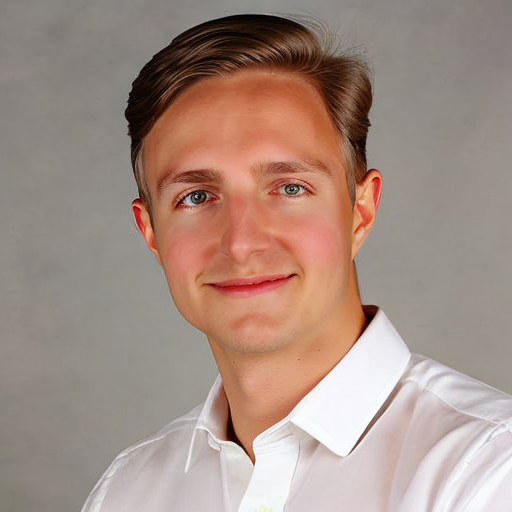

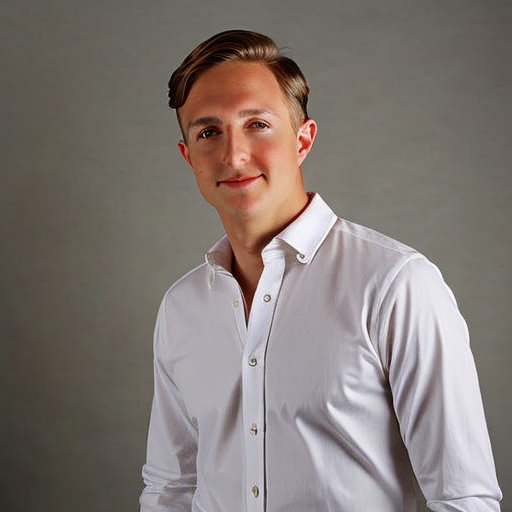

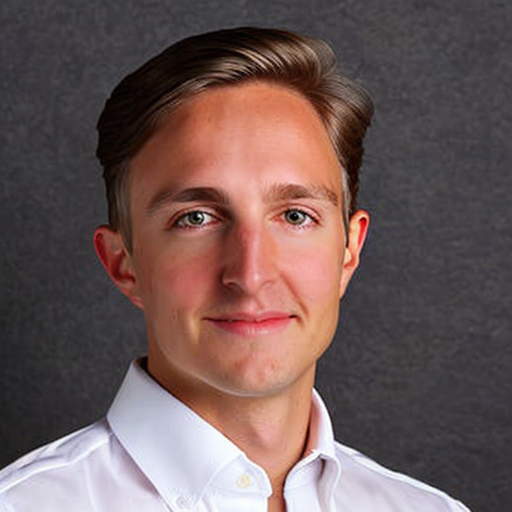

In [27]:
# Example prompt 1
#prompt = f"medium shot side profile portrait photo of the {YOUR_NAME_ABBREVIATION} {MAN_OR_WOMAN} warrior chief, tribal panther make up, blue on red, looking away, serious eyes, 50mm portrait, photography, hard rim lighting photography –ar 2:3 –beta –upbeta"
#negative_prompt = "blender, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"

# Example prompt 2
#prompt = f"a painting of a {YOUR_NAME_ABBREVIATION} thinker no facial hair, thoughtful, focused, visionary, calm, jovial, loving, fatherly, generous, elegant well fed elder with few eyebrows and his on from Kenya by Henry Ossawa Tanner . dramatic angle, ethereal lights, details, smooth, sharp focus, illustration, realistic, cinematic, artstation, award winning, rgb , unreal engine, octane render, cinematic light, macro, depth of field, blur, red light and clouds from the back, highly detailed epic cinematic concept art CG render made in Maya, Blender and Photoshop, octane render, excellent composition, dynamic dramatic cinematic lighting, aesthetic, very inspirational, arthouse"
#negative_prompt = "colourful 3d crystals and gems, vintage 1950s stamp, full color manga cover, kewpie, two girls, anime, fairytale illustration, chinese ribbon dance, children illustration, flower dress, illustration, silk shoes, classic children's illustrations, adorable and whimsical "

# Example prompt 3
prompt = f"comic book cover, {YOUR_NAME_ABBREVIATION}{MAN_OR_WOMAN} in the city, reddit, antipodeans, leading lines, preparing to fight, trending on imagestation, son, full device, some orange and blue, rear facing, netting, marvel, serious business, centered composition, wide shot "
#negative_prompt = "egyptian landscape, black and white old photo, black t - shirt"

# Example prompt 4
#prompt = f"mad (({YOUR_NAME_ABBREVIATION})) dwarf scientist working on the lab, alchemist, concept art, hearthstone official splash art, oceanside, full-shot, highres, hd wallpaper, album, despicable, legends, card game illustration, centered composition"
#negative_prompt = "troops searching the area, from police academy 2 (1985), gunma prefecture, concrete housing, nsfw, blur, wood block print, in africa, kodak tri - x 3 5 mm, black lace, american flag, football players, tokyo japan, ferrari 458, woodblock print"

# More prompts: Check out this great resource
# https://stability.ai/sdv2-prompt-book

#prompt = f"portrait photo of {YOUR_NAME_ABBREVIATION} {MAN_OR_WOMAN} in a beautiful blue suit, looking focused"
#negative_prompt = "blender, ugly, multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"

prompt = f"picture of {YOUR_NAME_ABBREVIATION} {MAN_OR_WOMAN} in a perfect white shirt, closeup, perfect eyes, front view, centered frame, symmetric, studio lighting, clear and realistic face, uhd faces, pexels, 85mm, casual pose, 35mm film roll photo, hard light, detailed skin texture, masterpiece, sharp focus, pretty, lovely, adorable, attractive, hasselblad, candid street portrait"
negative_prompt = "blender, jewlery, chain,ugly, different eye color ,multiple hands, bad anatomy, bad proportions, unrealistic, full body, cropped, lowres, poorly drawn face, out of frame, poorly drawn hands, double, blurred, disfigured, deformed, repetitive, black and white"

images = pipe(
    prompt,
    height=height,
    width=width,
    negative_prompt=negative_prompt,
    num_images_per_prompt=num_samples,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    generator=g_cuda
).images
for image in images:
  display(image)